In [1]:
# Various libraries to be imported
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score

In [2]:
# Reading the dataset
data = pd.read_csv('dataset.csv')
data.head(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/9/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/5/1996 0:00,11/4/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


### Data Preparation and Cleaning

In [3]:
#Generalizing the dataset. Changing the specific server names containing even the versions to their generic names
server_replacement_dict = { 'cloudflare': 'nginx', 'mw2180.codfw.wmnet' : 'Apache' , 'Yippee':'Yippee-Ki-Yay'}

def replacing_servers(server_list):
    
    
    for idx in range(len(server_list)):
        if server_list[idx] in server_replacement_dict:
            server_list[idx] = server_replacement_dict[server_list[idx]]
            
    return server_list

In [4]:
server_data = []

for idx in range(len(data['SERVER'])):
    temp = str(data['SERVER'][idx]).split('/')[0]
    temp = temp.split('-')[0]
    temp = temp.split('(')[0]
    temp = temp.split('+')[0]
    temp = temp.strip()
    server_data.append(replacing_servers(temp))

data['SERVER_FINAL'] = server_data

In [5]:
del data['SERVER']
data.head(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,...,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,SERVER_FINAL
0,M0_109,16,7,iso-8859-1,263.0,None,None,10/10/2015 18:21,None,7,...,2,700,9,10,1153,832,9,2.0,1,nginx
1,B0_2314,16,6,UTF-8,15087.0,None,None,None,None,17,...,4,1230,17,19,1265,1230,17,0.0,0,Apache
2,B0_911,16,6,us-ascii,324.0,None,None,None,None,0,...,0,0,0,0,0,0,0,0.0,0,Microsoft
3,B0_113,17,6,ISO-8859-1,162.0,US,AK,7/10/1997 4:00,12/9/2013 0:45,31,...,3,3812,39,37,18784,4380,39,8.0,0,nginx
4,B0_403,17,6,UTF-8,124140.0,US,TX,12/5/1996 0:00,11/4/2017 0:00,57,...,5,4278,61,62,129889,4586,61,4.0,0,None


In [6]:
# handling WHOIS_REGDATE
new = pd.DataFrame(data['WHOIS_REGDATE'].str.split(' ',1).tolist(),columns = ['date','time'])
new.replace('None', '00/00/0000', inplace= True)
del new['time']
new = pd.DataFrame(new['date'].str.split('/',2).tolist(),columns = ['day','month','year'])
data['WHOIS_REGDATE_MONTH'] = new.month
data['WHOIS_REGDATE_YEAR'] = new.year
del data['WHOIS_REGDATE']

### Replacing None by 0

In [7]:
data.replace('None', 0, inplace= True) 
data.fillna(0, inplace= True)

### Genralising the dates

In [8]:
data['WHOIS_UPDATED_DATE_YEAR'] =  pd.DatetimeIndex(data['WHOIS_UPDATED_DATE']).year
data['WHOIS_UPDATED_DATE_MONTH'] =  pd.DatetimeIndex(data['WHOIS_UPDATED_DATE']).month
del data['WHOIS_UPDATED_DATE']

### Removing Outliers

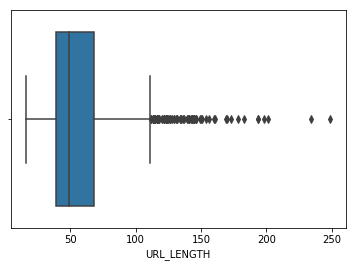

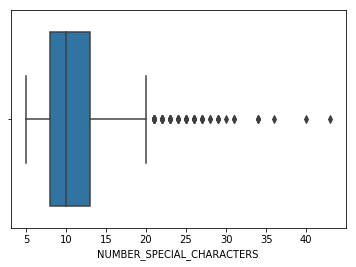

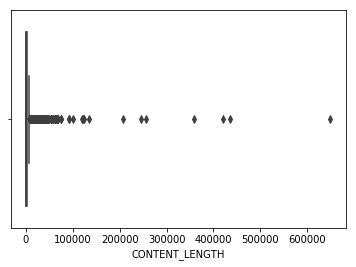

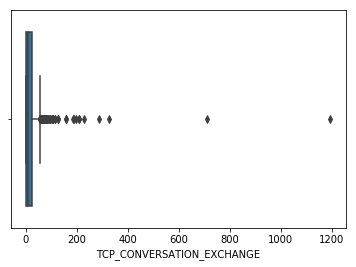

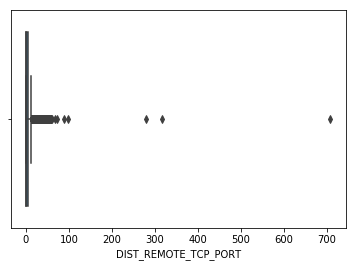

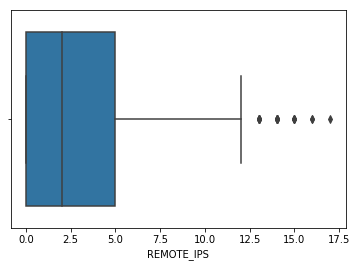

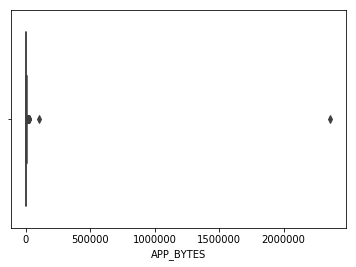

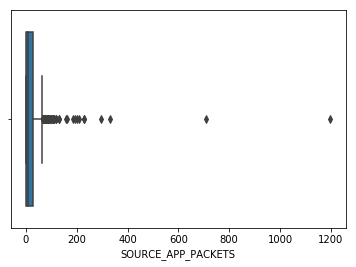

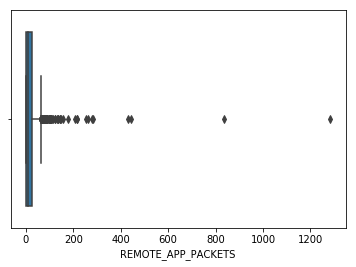

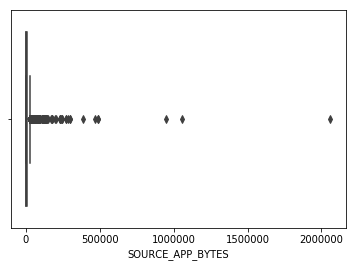

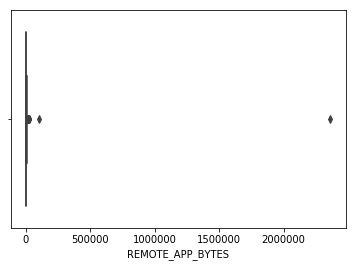

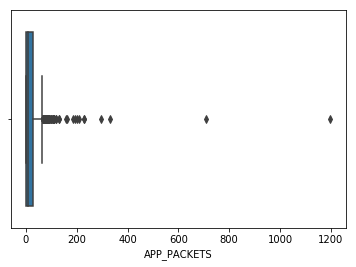

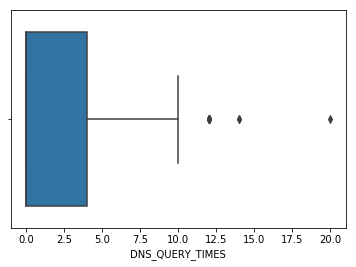

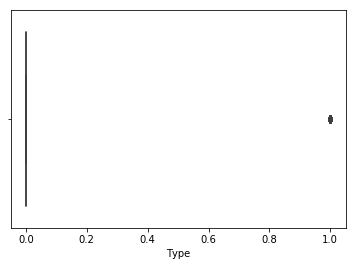

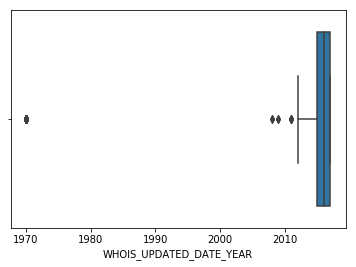

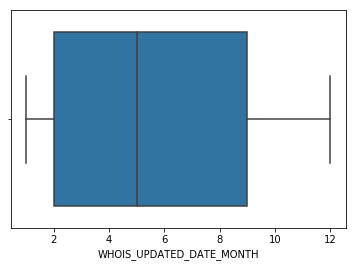

In [9]:
# to get numeric coloumns
num_cols = data._get_numeric_data().columns
#Vizualizing the data before cleaning
for col in num_cols:
    sns.boxplot(x=data[col])
    plt.show()

In [10]:
#### removing outliers which fall above 99 percentile
n_rows = len(data)

cols = ['URL_LENGTH','APP_BYTES','REMOTE_IPS','REMOTE_APP_BYTES']
final = data
for i in cols:
    p = np.percentile(final[i],99)
    print(p)
    data = data[data[i]<p]
print("Removed " + str(n_rows - len(data)) + " rows")

146.60000000000014
10554.600000000015
13.0
11229.800000000003
Removed 63 rows


In [11]:
def bin_allocation(col_name, bins, data):
    '''
    col_name:pass name of the columns,
    bins: number of bins to be generated,
    data: pass the dataframe
    '''
    max_value = data[col_name].max()
    min_value = data[col_name].min()
    
    n = bins ## number of intervals
    interval = (max_value - min_value) / n
    
    ##generating unique values based on range
    range_unique_value = {}

    start = min_value
    unique_value = 0 
    while (start <= max_value):



        if start not in range_unique_value:
            range_unique_value[start] = unique_value
            unique_value +=1
            start += interval
            
    key_list = list(range_unique_value.keys())
    
    final_result = []   ## final unique values 
    for data in data[col_name]:
        for idx in range(len(key_list)-1):
            if key_list[idx] <= data <= key_list[idx + 1]:
                final_result.append(range_unique_value[key_list[idx]])
                break
    
    return final_result

In [12]:
# creating a new coloumn and deleting original coloumn
data['URL_LENGTH_NEW'] = bin_allocation('URL_LENGTH', 5, data)
del data['URL_LENGTH']

In [13]:
# converting to lower case
data['CHARSET_LOWER'] = data['CHARSET'].str.lower()
del data['CHARSET'] 

In [14]:
app_bytes_list = bin_allocation('APP_BYTES', 15, data)
data['APP_BYTES_NEW'] = app_bytes_list
del data['APP_BYTES']

In [15]:
data['TCP_CONVERSATION_EXCHANGE_NEW'] = bin_allocation('TCP_CONVERSATION_EXCHANGE', 5, data)  ## 10 not proper
del data['TCP_CONVERSATION_EXCHANGE']

In [16]:
data['REMOTE_IPS'] = bin_allocation('REMOTE_IPS', 5, data)

In [17]:
data['SOURCE_APP_PACKETS_NEW'] = bin_allocation('SOURCE_APP_PACKETS', 6, data)
del data['SOURCE_APP_PACKETS']

In [18]:
data['APP_PACKETS_NEW'] = bin_allocation('APP_PACKETS', 11, data) 
del data['APP_PACKETS']

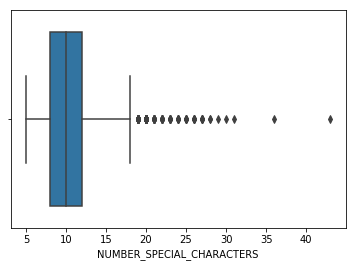

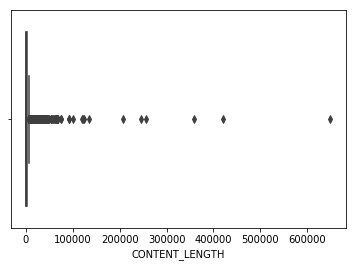

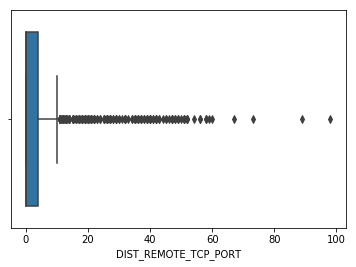

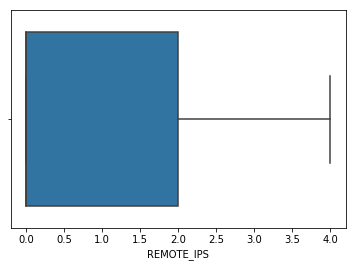

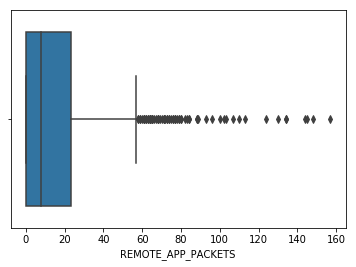

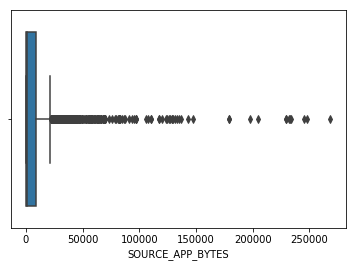

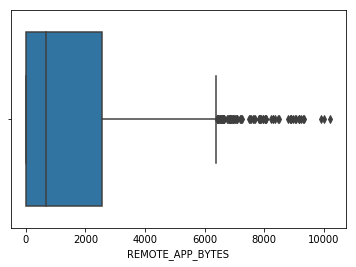

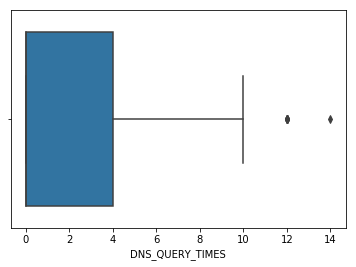

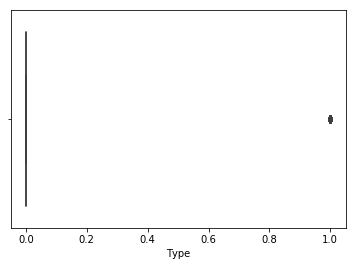

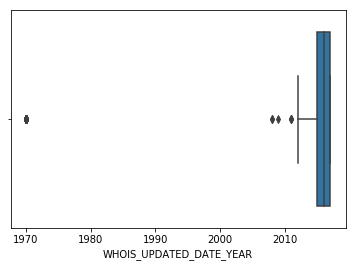

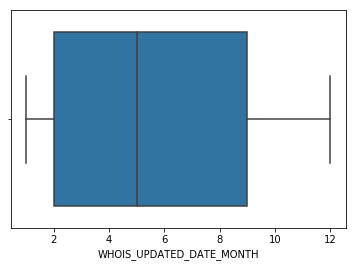

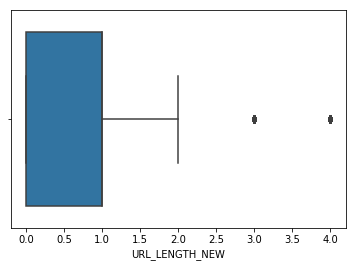

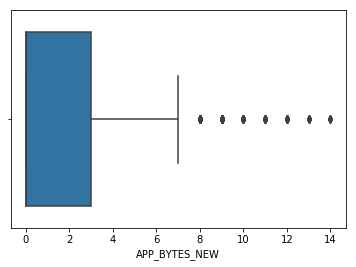

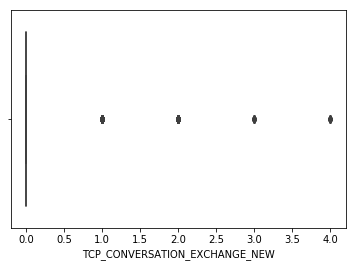

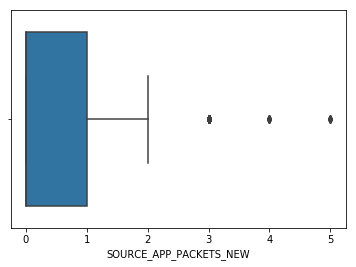

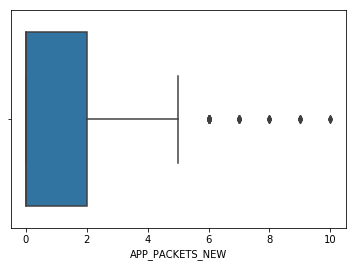

In [19]:
# vizualizing clean data
num_cols = data._get_numeric_data().columns
for col in num_cols:
    sns.boxplot(x=data[col])
    plt.show()

### Exploratory Data Analysis

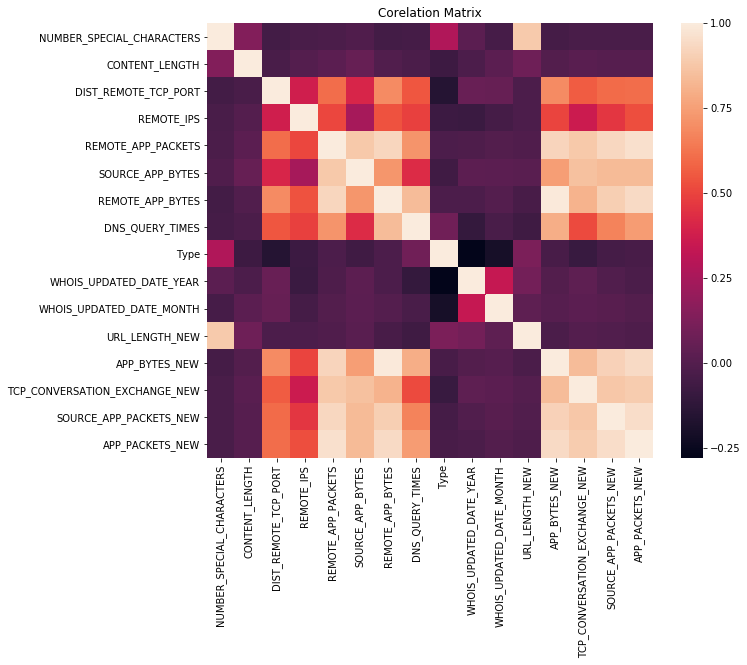

In [20]:
#corelation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
plt.title("Corelation Matrix")
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

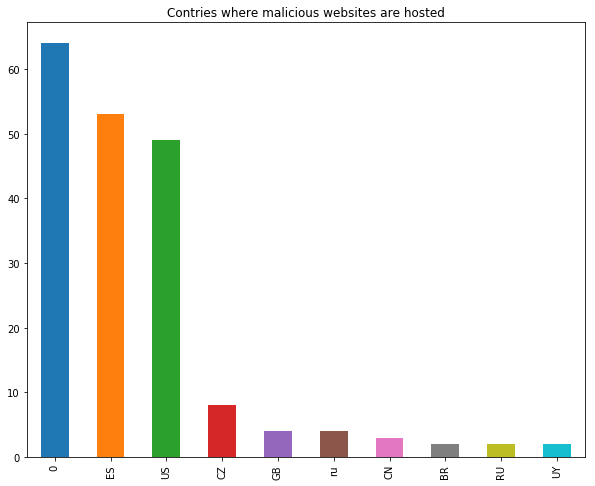

In [21]:
# Malicous websites server location
mal_data = data[data['Type']==1]
plt.figure(figsize=(10, 8))
plt.title("Contries where malicious websites are hosted")
mal_data['WHOIS_COUNTRY'].value_counts().nlargest(10).plot(kind='bar')

### OHE

In [22]:
# creating copy of original data
data_copy = data.copy()
data = pd.get_dummies(data)
data

,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type,WHOIS_UPDATED_DATE_YEAR,...,WHOIS_REGDATE_YEAR_2014,WHOIS_REGDATE_YEAR_2015,WHOIS_REGDATE_YEAR_2016,WHOIS_REGDATE_YEAR_2017,CHARSET_LOWER_iso-8859,CHARSET_LOWER_iso-8859-1,CHARSET_LOWER_us-ascii,CHARSET_LOWER_utf-8,CHARSET_LOWER_windows-1251,CHARSET_LOWER_windows-1252
0,7,263.0,0,0,10,1153,832,2.0,1,1970,...,0,1,0,0,0,1,0,0,0,0
1,6,15087.0,7,1,19,1265,1230,0.0,0,1970,...,0,0,0,0,0,0,0,1,0,0
2,6,324.0,0,0,0,0,0,0.0,0,1970,...,0,0,0,0,0,0,1,0,0,0
3,6,162.0,22,1,37,18784,4380,8.0,0,2013,...,0,0,0,0,0,1,0,0,0,0
4,6,124140.0,2,2,62,129889,4586,4.0,0,2017,...,0,0,0,0,0,0,0,1,0,0
5,7,0.0,6,3,13,838,894,0.0,0,2016,...,0,0,1,0,0,0,0,1,0,0
6,6,345.0,0,1,13,8559,1327,2.0,0,2016,...,0,0,0,0,0,1,0,0,0,0
7,6,324.0,0,0,0,0,0,0.0,0,2017,...,0,0,0,0,0,0,1,0,0,0
8,5,0.0,0,0,3,213,146,2.0,1,1970,...,1,0,0,0,0,0,0,1,0,0
9,5,0.0,0,0,1,62,146,2.0,1,1970,...,1,0,0,0,0,0,0,1,0,0


### Splitting data in X and Y

In [23]:
Y = data[['Type']]
del data['Type']
X = data

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state= 95885)

### Balancing the dataset

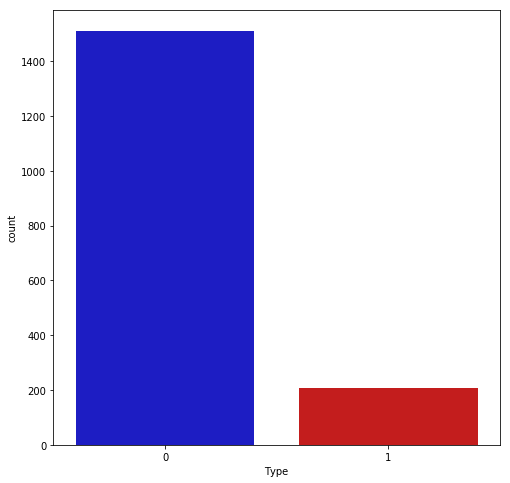

In [25]:
#converting into dataframes
df_target = pd.DataFrame(Y)
df_data = pd.DataFrame(X)
# color coding for 2 classes
colors = ["#0101DF", "#DF0101"]
i=0
## code to plot the class distribution. 
plt.figure(figsize=(8, 8))
sns.countplot(df_target['Type'], data=data,palette=colors)

In [26]:
ratio = round((Y==1).sum()/X.shape[0]*100,2)
print("Percentage of malicious websites:",ratio,"%")

Percentage of malicious websites: Type    11.99
dtype: float64 %


In [27]:
from imblearn.over_sampling import SMOTE #Over sampling

## Instantiate smote and balance training data only
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

## Compute and print percentage of high quality wine after balancing
print('Percentage of malicious websites after balancing :{}%'.format((y_train_res==1).sum()/X_train_res.shape[0]*100))

Percentage of malicious websites after balancing :50.0%


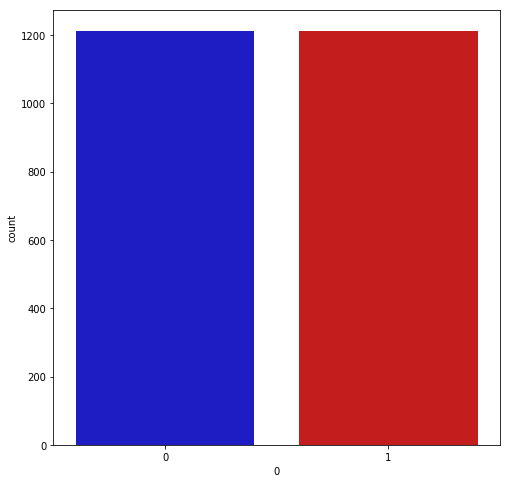

In [28]:
colors = ["#0101DF", "#DF0101"]

#converting to dataframes
df_X_smote= pd.DataFrame(X_train_res)
df_y_smote = pd.DataFrame(y_train_res)
## plot the class distribution of training data after balancing
plt.figure(figsize=(8, 8))
sns.countplot(df_y_smote[0], data=df_y_smote,palette=colors)

In [29]:
# Function to print all scores
def print_scores(y_test, y_pred, model_name):
    test_acc = accuracy_score(y_test, y_pred)
    print(model_name,'classifier accuracy:', test_acc)

    test_recall = recall_score(y_test, y_pred)
    print(model_name,'classifier recall:', test_recall)

    test_precision = precision_score(y_test, y_pred)
    print(model_name,'classifier Precision:', test_precision)

    test_f1 = f1_score(y_test, y_pred)
    print(model_name,'classifier f1 score:', test_f1)

    test_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name,'classifier roc_auc score:', test_roc_auc)
    

In [30]:
def plot_roc_auc_curve(best_model,y_pred):
    
    fpr, tpr, thresholds= roc_curve(y_test, y_pred)

    plt.figure(figsize = (13, 4.5))
    plt.subplot(2, 2, 1)
    plt.title("ROC Curve (AUC = %0.02f)"% roc_auc_score(y_test, y_pred))
    plt.plot(fpr, tpr, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [31]:
def fit_classifier(model,parameters,model_name):
    print("=================================================")
    print(model_name)
    print("=================================================")
    grid = GridSearchCV(model,param_grid=parameters,cv= 5)
    grid.fit(X_train_res,y_train_res)

    best_model = grid.best_estimator_
    print("Optimal parameters:",grid.best_params_)

    best_model.fit(X_train_res,y_train_res)
    y_pred = best_model.predict(X_test)

    # Printing all scores
    print_scores(y_test,y_pred,model_name)

    # ROC AUC Curve
    plot_roc_auc_curve(best_model,y_pred)
    

Multinomial Naive Bayes
Optimal parameters: {}
Multinomial Naive Bayes classifier accuracy: 0.39244186046511625
Multinomial Naive Bayes classifier recall: 0.9111111111111111
Multinomial Naive Bayes classifier Precision: 0.16666666666666666
Multinomial Naive Bayes classifier f1 score: 0.281786941580756
Multinomial Naive Bayes classifier roc_auc score: 0.6127461910070606


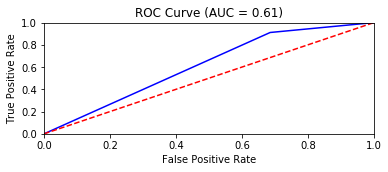

In [46]:
# Naive Bayes as baseline model without any hyperparameters
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
parameters = {}
fit_classifier(nb,parameters,'Multinomial Naive Bayes')

Random Forest
Optimal parameters: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
Random Forest classifier accuracy: 0.9505813953488372
Random Forest classifier recall: 0.8222222222222222
Random Forest classifier Precision: 0.8043478260869565
Random Forest classifier f1 score: 0.8131868131868132
Random Forest classifier roc_auc score: 0.8960609438870308


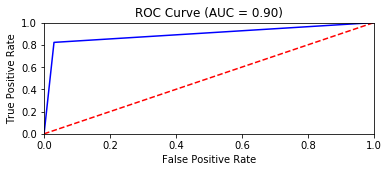

In [35]:
# Random Forest Classifier
random_forest=RandomForestClassifier()

cv_parameters = {'n_estimators':[50, 100,150,200],
                'max_depth':[3,4,5,6,7],
                 'criterion' :['gini', 'entropy']}

fit_classifier(random_forest,cv_parameters,'Random Forest')

K-Nearest Neighbours
Optimal parameters: {'n_neighbors': 1}
K-Nearest Neighbours classifier accuracy: 0.9244186046511628
K-Nearest Neighbours classifier recall: 0.8666666666666667
K-Nearest Neighbours classifier Precision: 0.6610169491525424
K-Nearest Neighbours classifier f1 score: 0.7500000000000001
K-Nearest Neighbours classifier roc_auc score: 0.8998885172798217


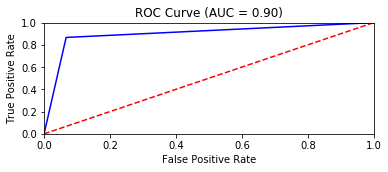

In [47]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier() # instantiate KNeighborsClassifier
param_grid = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
fit_classifier(kNN,param_grid,'K-Nearest Neighbours')

SVM
Optimal parameters: {'C': 10, 'gamma': 1e-05}
SVM classifier accuracy: 0.9418604651162791
SVM classifier recall: 0.7777777777777778
SVM classifier Precision: 0.7777777777777778
SVM classifier f1 score: 0.7777777777777778
SVM classifier roc_auc score: 0.872166480862133


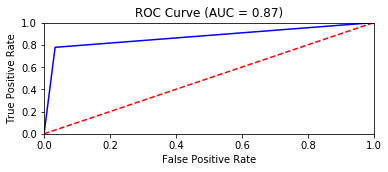

In [36]:
# SVM
from sklearn.svm import SVC
svc = SVC()
parameters = {'C':[1, 10, 100],'gamma': [1e-3,1e-4,1e-5]}
fit_classifier(svc,parameters,'SVM')

Multi-level Perceptron
Optimal parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
Multi-level Perceptron classifier accuracy: 0.8575581395348837
Multi-level Perceptron classifier recall: 0.7777777777777778
Multi-level Perceptron classifier Precision: 0.47297297297297297
Multi-level Perceptron classifier f1 score: 0.5882352941176471
Multi-level Perceptron classifier roc_auc score: 0.8236714975845411


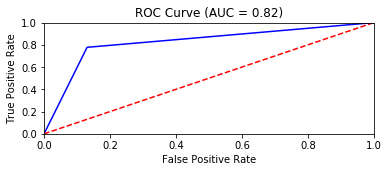

In [34]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu']}
fit_classifier(mlp,cv_parameters,'Multi-level Perceptron')